In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import datetime as dt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
tf.compat.v1.experimental.output_all_intermediates(True)

In [2]:
tf.random.set_seed(36)

## Dataset

In [3]:
BASE_DIR_PATH = '../Datasets'
DATASET_FILE = os.path.join(BASE_DIR_PATH, '2016_2017_sto_nino_and_montalban.csv')

In [4]:
df = pd.read_csv(DATASET_FILE)
df

,Unnamed: 0,datetime,month,day,hour,t,Station,x,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Discharge,Cross_Section,Velocity,fric_coeff,slope
0,0,2016-01-01 00:00:00,1,1,0,0.0,Montalban,0,0,1,2,0,0,21.03,14.842428,630.90,0.023526,0.035,0.002000
1,1,2016-01-01 00:00:00,1,1,0,0.0,Sto_Nino,14420,0,1,2,0,0,12.18,21.033407,803.88,0.026165,0.033,0.000667
2,2,2016-01-01 01:00:00,1,1,1,3600.0,Montalban,0,0,1,1,1,0,21.03,14.842428,630.90,0.023526,0.035,0.002000
3,3,2016-01-01 01:00:00,1,1,1,3600.0,Sto_Nino,14420,0,1,1,1,0,12.19,21.280072,804.54,0.026450,0.033,0.000667
4,4,2016-01-01 02:00:00,1,1,2,7200.0,Montalban,0,1,1,1,0,1,21.03,14.842428,630.90,0.023526,0.035,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,35035,2017-12-31 21:00:00,12,31,21,63147600.0,Sto_Nino,14420,0,0,0,0,0,12.44,28.244204,821.04,0.034401,0.033,0.000667
35036,35036,2017-12-31 22:00:00,12,31,22,63151200.0,Montalban,0,0,0,0,0,0,21.18,17.224575,635.40,0.027108,0.035,0.002000
35037,35037,2017-12-31 22:00:00,12,31,22,63151200.0,Sto_Nino,14420,0,0,0,0,0,12.44,28.244204,821.04,0.034401,0.033,0.000667
35038,35038,2017-12-31 23:00:00,12,31,23,63154800.0,Montalban,0,0,0,0,0,0,21.18,17.224575,635.40,0.027108,0.035,0.002000


In [5]:
df = df[['x', 't', 'fric_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'Waterlevel', 'Velocity']]
df

,x,t,fric_coeff,slope,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Velocity
0,0,0.0,0.035,0.002000,0,1,2,0,0,21.03,0.023526
1,14420,0.0,0.033,0.000667,0,1,2,0,0,12.18,0.026165
2,0,3600.0,0.035,0.002000,0,1,1,1,0,21.03,0.023526
3,14420,3600.0,0.033,0.000667,0,1,1,1,0,12.19,0.026450
4,0,7200.0,0.035,0.002000,1,1,1,0,1,21.03,0.023526
...,...,...,...,...,...,...,...,...,...,...,...
35035,14420,63147600.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35036,0,63151200.0,0.035,0.002000,0,0,0,0,0,21.18,0.027108
35037,14420,63151200.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35038,0,63154800.0,0.035,0.002000,0,0,0,0,0,21.18,0.027108


## Window Generator

In [6]:
sto_nino_df = df[df['x'] == 14420]
sto_nino_df

,x,t,fric_coeff,slope,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Velocity
1,14420,0.0,0.033,0.000667,0,1,2,0,0,12.18,0.026165
3,14420,3600.0,0.033,0.000667,0,1,1,1,0,12.19,0.026450
5,14420,7200.0,0.033,0.000667,1,1,1,0,1,12.19,0.026450
7,14420,10800.0,0.033,0.000667,0,0,0,1,0,12.20,0.026738
9,14420,14400.0,0.033,0.000667,1,1,1,0,0,12.20,0.026738
...,...,...,...,...,...,...,...,...,...,...,...
35031,14420,63140400.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35033,14420,63144000.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35035,14420,63147600.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35037,14420,63151200.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401


In [7]:
n = len(sto_nino_df)

In [8]:
sto_nino_train_df = sto_nino_df[0:int(n*0.5)]
sto_nino_val_df = sto_nino_df[int(n*0.5):int(n*0.75)]
sto_nino_test_df = sto_nino_df[int(n*0.75):]

In [9]:
montalban_df = df[df['x'] == 0]
montalban_df

,x,t,fric_coeff,slope,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Velocity
0,0,0.0,0.035,0.002,0,1,2,0,0,21.03,0.023526
2,0,3600.0,0.035,0.002,0,1,1,1,0,21.03,0.023526
4,0,7200.0,0.035,0.002,1,1,1,0,1,21.03,0.023526
6,0,10800.0,0.035,0.002,0,0,0,1,0,21.03,0.023526
8,0,14400.0,0.035,0.002,1,1,1,0,0,21.03,0.023526
...,...,...,...,...,...,...,...,...,...,...,...
35030,0,63140400.0,0.035,0.002,0,0,0,0,0,21.18,0.027108
35032,0,63144000.0,0.035,0.002,0,0,0,0,0,21.18,0.027108
35034,0,63147600.0,0.035,0.002,0,0,0,0,0,21.18,0.027108
35036,0,63151200.0,0.035,0.002,0,0,0,0,0,21.18,0.027108


In [10]:
montalban_train_df = montalban_df[0:int(n*0.5)]
montalban_val_df = montalban_df[int(n*0.5):int(n*0.75)]
montalban_test_df = montalban_df[int(n*0.75):]

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, False)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [12]:
sto_nino_window = WindowGenerator(
        input_width=6, label_width=6, shift=1,
        train_df = sto_nino_train_df,
        val_df = sto_nino_val_df,
        test_df = sto_nino_test_df,
        label_columns=['Waterlevel', 'Velocity']
    )

sto_nino_window 

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['Waterlevel', 'Velocity']

In [13]:
montalban_window = WindowGenerator(
        input_width=6, label_width=6, shift=1,
        train_df = montalban_train_df,
        val_df = montalban_val_df,
        test_df = montalban_test_df,
        label_columns=['Waterlevel', 'Velocity']
    )

montalban_window 

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['Waterlevel', 'Velocity']

In [14]:
train_ds = sto_nino_window.train.concatenate(montalban_window.train)
train_ds = train_ds.shuffle(buffer_size=len(list(train_ds)))

val_ds = sto_nino_window.val.concatenate(montalban_window.val)
val_ds = val_ds.shuffle(buffer_size=len(list(val_ds)))

test_ds = sto_nino_window.test.concatenate(montalban_window.test)
test_ds = test_ds.shuffle(buffer_size=len(list(test_ds)))

## Evaluation Metrics

In [15]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [16]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Training

In [17]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, train_data=train_ds, val_data=val_ds, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        train_data, 
        epochs=MAX_EPOCHS,
        validation_data=val_data,
        callbacks=[early_stopping]
    )

    return history

In [18]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2)
])

In [19]:
lstm_history = compile_and_fit(lstm_model)

Epoch 1/20
548/548 [==============================] - 8s 8ms/step - loss: 19.8154 - mean_squared_error: 19.8154 - NSE: 0.7063 - r_square: 5.6390e-04 - val_loss: 10.7806 - val_mean_squared_error: 10.7806 - val_NSE: 0.7681 - val_r_square: 2.0703e-14
Epoch 2/20
548/548 [==============================] - 4s 7ms/step - loss: 10.2353 - mean_squared_error: 10.2354 - NSE: 0.8221 - r_square: 1.2988e-04 - val_loss: 10.5247 - val_mean_squared_error: 10.5247 - val_NSE: 0.8202 - val_r_square: 2.5219e-14
Epoch 3/20
548/548 [==============================] - 4s 6ms/step - loss: 10.4630 - mean_squared_error: 10.4630 - NSE: 0.8187 - r_square: 9.5532e-05 - val_loss: 10.5520 - val_mean_squared_error: 10.5520 - val_NSE: 0.7851 - val_r_square: 5.3899e-15
Epoch 4/20
548/548 [==============================] - 4s 6ms/step - loss: 10.1961 - mean_squared_error: 10.1961 - NSE: 0.8226 - r_square: 8.0056e-05 - val_loss: 10.9024 - val_mean_squared_error: 10.9024 - val_NSE: 0.8401 - val_r_square: 1.9026e-14


## Predictions

In [20]:
sto_nino_test_df

,x,t,fric_coeff,slope,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Velocity
26281,14420,47390400.0,0.033,0.000667,0,0,0,0,0,11.89,0.018882
26283,14420,47394000.0,0.033,0.000667,0,0,0,0,0,11.87,0.018446
26285,14420,47397600.0,0.033,0.000667,0,0,0,0,0,11.85,0.018017
26287,14420,47401200.0,0.033,0.000667,0,4,0,0,0,11.84,0.017806
26289,14420,47404800.0,0.033,0.000667,11,19,0,22,0,11.84,0.017806
...,...,...,...,...,...,...,...,...,...,...,...
35031,14420,63140400.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35033,14420,63144000.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35035,14420,63147600.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401
35037,14420,63151200.0,0.033,0.000667,0,0,0,0,0,12.44,0.034401


In [21]:
sto_nino_y_true = sto_nino_test_df[['Waterlevel', 'Velocity']]
sto_nino_y_true = sto_nino_y_true.values
sto_nino_y_true

array([[11.89      ,  0.01888235],
       [11.87      ,  0.01844587],
       [11.85      ,  0.0180173 ],
       ...,
       [12.44      ,  0.03440052],
       [12.44      ,  0.03440052],
       [12.44      ,  0.03440052]])

In [22]:
sto_nino_y_true_h = sto_nino_y_true[1:,0]
sto_nino_y_true_v = sto_nino_y_true[1:,1]

In [23]:
np.set_printoptions(suppress=True)

In [24]:
for x, y in sto_nino_window.test.take(1):
    print(x[:2])
    print(lstm_model(x[:2]))
    print(y[:2])
    break

tf.Tensor(
[[[   14420.         47390400.                0.033
          0.00066667        0.                0.
          0.                0.                0.
         11.89              0.01888235]
  [   14420.         47394000.                0.033
          0.00066667        0.                0.
          0.                0.                0.
         11.87              0.01844587]
  [   14420.         47397600.                0.033
          0.00066667        0.                0.
          0.                0.                0.
         11.85              0.0180173 ]
  [   14420.         47401200.                0.033
          0.00066667        0.                4.
          0.                0.                0.
         11.84              0.01780595]
  [   14420.         47404800.                0.033
          0.00066667       11.               19.
          0.               22.                0.
         11.84              0.01780595]
  [   14420.         47408400.         

In [25]:
sto_nino_y_pred_h = []
sto_nino_y_pred_v = []
batch_num = 1

for x, y in sto_nino_window.test:
    predictions = lstm_model(x)
    
    if batch_num == 1:
        for i in range(len(predictions[0])):
            sto_nino_y_pred_h.append(predictions[0][i][0])
            sto_nino_y_pred_v.append(predictions[0][i][1])
            
        for i in range(1, len(predictions)):
            sto_nino_y_pred_h.append(predictions[i][-1][0])
            sto_nino_y_pred_v.append(predictions[i][-1][1])
            
        batch_num += 1
        
    else:
        for i in range(len(predictions)):
            sto_nino_y_pred_h.append(predictions[i][-1][0])
            sto_nino_y_pred_v.append(predictions[i][-1][1])
            
sto_nino_y_pred_h = np.array(sto_nino_y_pred_h)
sto_nino_y_pred_v = np.array(sto_nino_y_pred_v)

In [26]:
sto_nino_y_pred_h

array([14.351648, 15.552531, 15.73925 , ..., 15.768936, 15.768936,
       15.768936], dtype=float32)

In [27]:
sto_nino_SS_res_h = np.sum(np.square(sto_nino_y_true_h - sto_nino_y_pred_h)) 
sto_nino_SS_tot_h = np.sum(np.square(sto_nino_y_true_h - np.mean(sto_nino_y_true_h))) 

sto_nino_nse_h =  1 - sto_nino_SS_res_h/sto_nino_SS_tot_h
sto_nino_nse_h

-31.601853304467177

In [28]:
import matplotlib.pyplot as plt

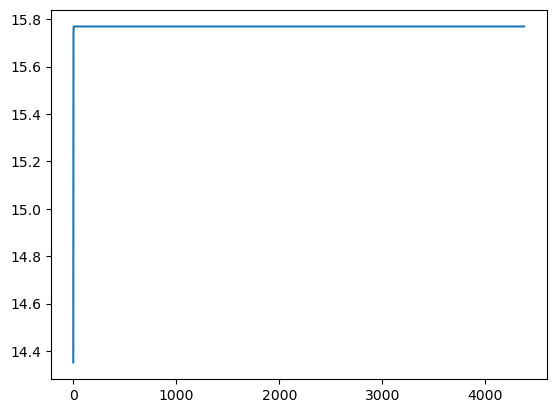

In [29]:
plt.plot(sto_nino_y_pred_h)